# Swaption Calibration

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Import Data](#p1)

# [2. Displaced Diffusion Model](#p2)

# [3. SABR Model](#p3)

# [4. Check Calibration](#p4)

# [5. Pricing Swaptions](#p5)

In [1]:
import math
import numpy as np
import scipy.stats as si
from scipy.stats import norm
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import plotly.graph_objects as go
import pandas as pd
import datetime as dt

from scipy.optimize import brentq
from scipy.stats import norm
from scipy.optimize import least_squares

import warnings

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# <a id = "p1">1.</a>  <font color = "green"> Import Data </font>  [back to table of contents](#top)

In [2]:
IRS_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="IRS",
                         usecols="A:C")
IRS_data

,Tenor,Product,Rate
0,6m,LIBOR,0.0250
1,1y,IRS,0.0280
2,2y,IRS,0.0300
3,3y,IRS,0.0315
4,4y,IRS,0.0325
5,5y,IRS,0.0330
6,7y,IRS,0.0350
7,10y,IRS,0.0370
8,15y,IRS,0.0400
9,20y,IRS,0.0450


In [3]:
OIS_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="OIS",
                         usecols="A:C")
OIS_data

,Tenor,Product,Rate
0,6m,OIS,0.00250
1,1y,OIS,0.00300
2,2y,OIS,0.00325
3,3y,OIS,0.00335
4,4y,OIS,0.00350
5,5y,OIS,0.00360
6,7y,OIS,0.00400
7,10y,OIS,0.00450
8,15y,OIS,0.00500
9,20y,OIS,0.00525


In [4]:
Swaption_data = pd.read_excel("IR Data.xlsx",
                         sheet_name="Swaption",
                         usecols="A:M",
                         skiprows=2)
Swaption_data

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1Y,2Y,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1Y,3Y,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1Y,5Y,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1Y,10Y,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5Y,1Y,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5Y,2Y,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5Y,3Y,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5Y,5Y,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5Y,10Y,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [5]:
Forward_rate = pd.read_csv("Forward_swap_rates_df.csv")
Forward_rate

,Start,Tenor,Forward_Swap_Rates
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634


In [6]:
Discount_Factors = pd.read_csv("Discount_Factors.csv")
Discount_Factors

,Years,Rate,OIS_Discount_Factor,IRS_Discount_Factor,Forward_LIBOR
0,0.5,0.025000,0.998752,0.987654,0.025000
1,1.0,0.028000,0.997009,0.972577,0.031245
2,1.5,0.029000,0.995270,0.957378,0.031242
3,2.0,0.030000,0.993531,0.942179,0.033275
4,2.5,0.030750,0.991773,0.926330,0.034038
5,3.0,0.031500,0.990015,0.910482,0.035565
6,3.5,0.032000,0.988066,0.894731,0.035309
7,4.0,0.032500,0.986117,0.878981,0.036328
8,4.5,0.032750,0.984150,0.863985,0.035053
9,5.0,0.033000,0.982184,0.848989,0.035562


In [7]:
# ATM is forward_swap_rates, the other values are ATM forward_swap_rates adjusted accordingly

df_strike = pd.DataFrame()
bps = np.array([-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200])/1e4
for i in list(Forward_rate["Forward_Swap_Rates"]):
    df_strike = pd.concat([df_strike, pd.DataFrame(i+bps)], axis = 1)
df_strike.index = Swaption_data.columns[2:13]
df_strike.columns = [(x,y) for x, y in zip(Swaption_data["Expiry"], Swaption_data["Tenor"])]

In [8]:
df_strike

,"(1Y, 1Y)","(1Y, 2Y)","(1Y, 3Y)","(1Y, 5Y)","(1Y, 10Y)","(5Y, 1Y)","(5Y, 2Y)","(5Y, 3Y)","(5Y, 5Y)","(5Y, 10Y)","(10Y, 1Y)","(10Y, 2Y)","(10Y, 3Y)","(10Y, 5Y)","(10Y, 10Y)"
-200bps,0.012007,0.013259,0.014011,0.015255,0.018428,0.019274,0.020075,0.020072,0.021093,0.023634,0.022189,0.023116,0.024097,0.026249,0.033458
-150bps,0.017007,0.018259,0.019011,0.020255,0.023428,0.024274,0.025075,0.025072,0.026093,0.028634,0.027189,0.028116,0.029097,0.031249,0.038458
-100bps,0.022007,0.023259,0.024011,0.025255,0.028428,0.029274,0.030075,0.030072,0.031093,0.033634,0.032189,0.033116,0.034097,0.036249,0.043458
-50bps,0.027007,0.028259,0.029011,0.030255,0.033428,0.034274,0.035075,0.035072,0.036093,0.038634,0.037189,0.038116,0.039097,0.041249,0.048458
-25bps,0.029507,0.030759,0.031511,0.032755,0.035928,0.036774,0.037575,0.037572,0.038593,0.041134,0.039689,0.040616,0.041597,0.043749,0.050958
ATM,0.032007,0.033259,0.034011,0.035255,0.038428,0.039274,0.040075,0.040072,0.041093,0.043634,0.042189,0.043116,0.044097,0.046249,0.053458
+25bps,0.034507,0.035759,0.036511,0.037755,0.040928,0.041774,0.042575,0.042572,0.043593,0.046134,0.044689,0.045616,0.046597,0.048749,0.055958
+50bps,0.037007,0.038259,0.039011,0.040255,0.043428,0.044274,0.045075,0.045072,0.046093,0.048634,0.047189,0.048116,0.049097,0.051249,0.058458
+100bps,0.042007,0.043259,0.044011,0.045255,0.048428,0.049274,0.050075,0.050072,0.051093,0.053634,0.052189,0.053116,0.054097,0.056249,0.063458
+150bps,0.047007,0.048259,0.049011,0.050255,0.053428,0.054274,0.055075,0.055072,0.056093,0.058634,0.057189,0.058116,0.059097,0.061249,0.068458


# <a id = "p2">2.</a>  <font color = "green"> Displaced Diffusion Model </font>  [back to table of contents](#top)

In [9]:
# These are the ATM swaption volatilities
pd.concat([Swaption_data[["Expiry", "Tenor"]],
           Swaption_data["ATM"]/100],
          axis=1)

,Expiry,Tenor,ATM
0,1Y,1Y,0.2250
1,1Y,2Y,0.2872
2,1Y,3Y,0.2978
3,1Y,5Y,0.2607
4,1Y,10Y,0.2447
5,5Y,1Y,0.2726
6,5Y,2Y,0.2983
7,5Y,3Y,0.2998
8,5Y,5Y,0.2660
9,5Y,10Y,0.2451


## Valuing a swaption
$$
\text{Payer Swaption} = \left[ P_{n+1,N}(T) \left( S_{n,N}(T) - K \right) \right]^+
$$
$$
\text{Receiver Swaption} = \left[ P_{n+1,N}(T) \left( K - S_{n,N}(T) \right) \right]^+
$$

Using PVBP as risk neutral numeraire, and applying Black lognormal model
$$
\begin{aligned}
\frac{V^{\text{payer}}_{n,N} (0)}{P_{n+1,N} (0)} &= \mathbb{E}^{n+1,N} \left[ \frac{V^{\text{payer}}_{n,N} (T_n)}{P_{n+1,N} (T_n)} \right] \\
\Rightarrow V^{\text{payer}}_{n,N} (0) &= P_{n+1,N} (0) \mathbb{E}^{n+1,N} \left[ (S_{n,N} (T) - K)^+ \right] \\ \\
V^{\text{payer}}_{n,N} (0) = & P_{n+1,N} (0) \left[ S_{n,N} (0) \Phi(d_1) - K \Phi(d_2)  \right]
\end{aligned}
$$

In [10]:
#calculate PVBP
def calc_pvbp(t_begin, 
              t_end):
    
    '''
    t_begin: The start time (in years).
    t_end: The end time (in years).
    '''
    # Add 0.5 to the start as it starts paying only on the next coupon date (excluding first date)
    index_start = Discount_Factors[Discount_Factors["Years"] == t_begin+0.5].index[0]
    
    index_end = Discount_Factors[Discount_Factors["Years"] == t_end].index[0]
    
    # Get all the discount factors that need to be summed up
    discount_window = Discount_Factors.loc[index_start:index_end, "OIS_Discount_Factor"]
    
    # Sum all the discount factors and multiply by 0.5 as it is paid semi-annually
    pvbp = sum(0.5*discount_window)
    
    return pvbp

In [ ]:
def black76_payer(F, K, t, T, sigma):
    '''
    F: Forward swap rate (the price of the underlying swap).
    K: Strike price (the strike rate of the swaption).
    t: Time to swaption expiry in years
    T: Tenor of underlying swap in years
    sigma: Volatility (annualized standard deviation) of the underlying swap rate.
    '''
    pvbp = calc_pvbp(t, t+T)
    d1 = (np.log(F/K)+(1/2)*(sigma**2)*t)/(sigma*np.sqrt(t))        # t or T?
    d2 = d1 - sigma * np.sqrt(t)                                    # t or T?
    price = pvbp * ((F*norm.cdf(d1)) - (K*norm.cdf(d2)))
    return price

In [ ]:
def black76_receiver(F, K, t, T, sigma):
    '''
    F: Forward swap rate (the price of the underlying swap).
    K: Strike price (the strike rate of the swaption).
    t: Time to swaption expiry in years
    T: Tenor of underlying swap in years
    sigma: Volatility (annualized standard deviation) of the underlying swap rate.
    '''
    pvbp = calc_pvbp(t, t+T)
    d1 = (np.log(F/K)+1/2*(sigma**2)*t)/(sigma*np.sqrt(t))          # t or T?
    d2 = d1 - sigma * np.sqrt(t)                                    # t or T?
    price = pvbp * ((K*norm.cdf(-d2)) - (F*norm.cdf(-d1)))
    return price

In [ ]:
#Function of calculating implied volatility
def impliedVolatility_bs(S, 
                         K, 
                         price, 
                         t, 
                         T, 
                         payoff):
    
    '''
    S: The forward swap rate (the price of the underlying swap).
    K: Strike price of the option (for the swaption).
    price: The market price of the swaption.
    t: Time to swaption expiry in years
    T: Tenor of underlying swap in years
    payoff: Type of option — either 'call' (payer swaption) or 'put' (receiver swaption).
    '''
    
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                black76_payer(S, K, t, T, x),
                                1e-12, 1000.0)
            
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                black76_receiver(S, K, t, T, x),
                                1e-12, 1000.0)
            
        else:
            raise NameError('Payoff type not recognized')
        
    except Exception:
        impliedVol = np.nan
        
    return impliedVol

In [14]:
#Displaced-Diffusion pricing formula
def dd_calc_price(T, 
                  t, 
                  F, 
                  K, 
                  beta, 
                  sigma, 
                  payoff):
    
    if (payoff.lower() == 'call'):
        return(black76_payer(F/beta, K+((1-beta)/beta)*F, t, T, sigma*beta))
    
    elif (payoff.lower() == 'put'):
        return(black76_receiver(F/beta, K+((1-beta)/beta)*F, t, T, sigma*beta))

In [ ]:
#Displaced-Diffusion calibration
def ddcalibration(x, 
                  strikes, 
                  vols, 
                  S, 
                  t, 
                  T, 
                  sigma, 
                  payoff):
    
    '''
    x: The displacement factor β (initial guess).
    strikes: List/array of the strike prices for the swaptions.
    vols: List/array of market-implied volatilities for the swaptions.
    S: The forward swap rate (price of the underlying swap).
    t: Time to swaption expiry in years.
    T: Tenor of underlying swap in years.
    sigma: Volatility (annualized) of the underlying swap rate (for DD model).
    payoff: List of the payoffs for each swaption, where each element is either 'call' (payer swaption) or 'put' (receiver swaption).
    '''
    err = 0.0
    for j, vol in enumerate(vols):
        price = dd_calc_price(T, t, S, strikes[j], x[0], sigma, payoff[j])
        err += (vol - impliedVolatility_bs(S, strikes[j], price, t, T, payoff[j]))**2
        #print(j)
    return err

In [ ]:
# Calibrate the displacement factor β by minimizing the sum of squared errors (SSE) 
# between market-implied volatilities (implied_vol) and volatilities implied by the Displaced-Diffusion model for given strikes.

def DD_fit_beta(strike, 
                implied_vol, 
                S, 
                t, 
                T, 
                sigma, 
                payoff):
    
    '''
    strike: The list or array of strike prices for the swaptions.
    implied_vol: The list or array of market-implied volatilities for the swaptions.
    S: The forward swap rate (price of the underlying swap).
    t: Time to swaption expiry in years.
    T: Tenor of underlying swap in years.
    sigma: Volatility (annualized) of the underlying swap rate.
    payoff: The list of payoffs for each option ('call' or 'put').
    '''
    
    initialGuess = [0.7]
    bounds = (0,1)
    res = least_squares(lambda x: ddcalibration(x,
                                              strike,
                                              implied_vol,
                                              S, 
                                              t,
                                              T, 
                                              sigma, 
                                              payoff),
                    initialGuess, bounds = bounds)
    return res.x[0]

In [17]:
swap_data1 = Swaption_data.copy()
swap_data1["Tenor"] = [1,2,3,5,10,1,2,3,5,10,1,2,3,5,10]
swap_data1["Expiry"] = [1,1,1,1,1,5,5,5,5,5,10,10,10,10,10]
swap_data1

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1,2,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1,3,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1,5,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1,10,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5,1,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5,2,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5,3,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5,5,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5,10,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [18]:
# Calibrating beta for displaced-diffusion model

beta_list = []
for i in range(len(swap_data1)):
    ivol = swap_data1.iloc[i,2:]/100
    strike = df_strike.iloc[:,i]
    par_rate = Forward_rate["Forward_Swap_Rates"][i]
    df = pd.DataFrame({"ivol": ivol, "K": strike})
    df["payoff"] = df["K"].apply(lambda x: 'call' if x > par_rate else 'put')
    
    beta = DD_fit_beta(strike = df["K"], 
                       implied_vol = df["ivol"], 
                       S = par_rate, 
                       t = swap_data1["Expiry"][i], 
                       T = swap_data1["Tenor"][i], 
                       sigma = swap_data1["ATM"][i]/100, 
                       payoff = df["payoff"])
    
    beta_list.append(beta)
    
beta_list

[1.638113337770918e-10,
 9.815395375541754e-08,
 5.731735059911823e-07,
 9.601259517749074e-07,
 0.0002384479072254954,
 2.4841331981793457e-07,
 1.76534239027372e-08,
 4.2837845792378405e-06,
 7.319718055369276e-06,
 0.10810650735582795,
 6.907810043621127e-07,
 4.4007823529247387e-07,
 1.8681183464773314e-05,
 2.2239134175829805e-06,
 0.0006459046162847603]

In [19]:
Displaced_Diffusion_Beta_df = pd.DataFrame({"Expiry": swap_data1["Expiry"], 
                                            "Tenor": swap_data1["Tenor"], 
                                            "Beta": beta_list})

Displaced_Diffusion_Beta_df = Displaced_Diffusion_Beta_df.pivot(index="Expiry",
                                                                columns = "Tenor",
                                                                values = "Beta")

Displaced_Diffusion_Beta_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,1.638113e-10,9.815395e-08,5.731735e-07,9.601260e-07,0.000238
5,2.484133e-07,1.765342e-08,4.283785e-06,7.319718e-06,0.108107
10,6.907810e-07,4.400782e-07,1.868118e-05,2.223913e-06,0.000646


In [20]:
Displaced_Diffusion_Sigma_df = pd.DataFrame({"Expiry": swap_data1["Expiry"], 
                                            "Tenor": swap_data1["Tenor"], 
                                            "Sigma": swap_data1["ATM"]/100})

Displaced_Diffusion_Sigma_df = Displaced_Diffusion_Sigma_df.pivot(index="Expiry",
                                                                columns = "Tenor",
                                                                values = "Sigma")

Displaced_Diffusion_Sigma_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.2250,0.2872,0.2978,0.2607,0.2447
5,0.2726,0.2983,0.2998,0.2660,0.2451
10,0.2854,0.2928,0.2940,0.2674,0.2437


In [ ]:
# Calculate the Displaced-Diffusion (DD) model volatilities for a given set of swaptions
def calc_dd_vol(df,
                T,
                t,
                S,
                beta,
                sigma):
    
    '''
    df: A pandas DataFrame containing data for each swaption (strike price K, payoff type, etc.).
    t: Time to swaption expiry in years.
    T: Tenor of underlying swap in years.
    S: The forward swap rate (price of the underlying swap).
    beta: The displacement factor used in the Displaced-Diffusion model.
    sigma: The volatility (annualized standard deviation) of the underlying swap rate.
    '''
    
    df["price_dd"] = df.apply(lambda x: dd_calc_price (T, 
                                                        t, 
                                                        S, 
                                                        x["K"], 
                                                        beta, 
                                                        sigma, 
                                                        x["payoff"]),axis=1)
    
    df['vols_dd'] = df.apply(lambda x: impliedVolatility_bs(S,
                                                            x["K"],
                                                            x['price_dd'],
                                                            t, 
                                                            T,
                                                            x["payoff"]),axis=1)
    
    return df

In [ ]:
# Calculate the implied volatilities for swaptions using the Displaced-Diffusion (DD) model.

def dd_calc_vol(i):
    ivol = swap_data1.iloc[i,2:]/100
    strike = df_strike.iloc[:,i]
    par_rate = Forward_rate["Forward_Swap_Rates"][i]
    df = pd.DataFrame({"ivol": ivol, "K": strike})
    df["payoff"] = df["K"].apply(lambda x: 'call' if x > par_rate else 'put')
    beta = beta_list[i]
    calc_dd_vol(df, 
                swap_data1["Tenor"][i], 
                swap_data1["Expiry"][i], 
                par_rate, 
                beta, 
                swap_data1["ATM"][i]/100)
    
    return df["vols_dd"]

# <a id = "p3">3.</a>  <font color = "green"> SABR Model </font>  [back to table of contents](#top)

In [ ]:
def SABR(F, 
         K, 
         T, 
         alpha, 
         beta, 
         rho, 
         nu):
    
    '''
    F: The forward price or swap rate (forward value of the underlying asset).
    K: The strike price of the option.
    T: The time to maturity of the option (in years).
    alpha: The volatility parameter (scale factor).
    beta: The parameter that controls the volatility skew, typically between 0 and 1.
    rho: The correlation between the underlying asset and volatility (typically between -1 and 1).
    nu: The volatility of volatility (vol-vol), which controls how much the volatility can vary.
    '''
    
    X = K
    if np.isclose(F, K).all():
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [ ]:
# Calculates the sum of squared errors between the observed market swaption volatilities 
# and the volatilities predicted by the SABR model for a range of strike prices. 

def sabrcalibration(x, 
                    row, 
                    beta):    #x is a df there
    
    err = 0.0
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    vols = row.iloc[3:14]
    F = row.iloc[2]
    T = row.iloc[0]
    
    for i, vol in enumerate(vols):
        K = F + bp_changes[i]
        err += (vol - SABR(F, K, T, x[0], beta, x[1], x[2]))**2
        
    return err

In [ ]:
# Uses a least squares optimization procedure to minimize the error between the observed market volatilities and those predicted by the SABR model.

def sabr_vol(row):
    beta = 0.9                              #  Sets the skew parameter beta of the SABR model to 0.9
    #sarb to fit market vol
    #different initial guess values will lead to different calibration results (very small difference)
    #bounds of three parameters also cause uncertainty of our results
    #thus we take the average of multiple results and perform multiple iterations
    #and finally find the guess value below can generate a relatively good calibration
    initialGuess = [0.2, -0.5, 1.05]        # These are the initial guesses for the SABR parameters [alpha, rho, nu]

    res = least_squares(lambda x: sabrcalibration(x, row, beta), initialGuess, max_nfev= 2000)
    alpha1 = res.x[0]
    rho1 = res.x[1]
    nu1 = res.x[2]

    return [alpha1, rho1, nu1]

In [ ]:
'''
Creates a dataframe with 

start: expiry dates of the swaptions.
tenor: tenors of the swaptions.
fsr: forward swap rates
the rest of the columns are the implied vols for the corresponding strikes

'''
fsr = pd.DataFrame({"start": swap_data1["Expiry"], 
                    "tenor": swap_data1["Tenor"], 
                    "fsr": Forward_rate["Forward_Swap_Rates"]})

fsr[Swaption_data.columns[2:]] = Swaption_data[Swaption_data.columns[2:]]/100

fsr

,start,tenor,fsr,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.032007,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297
1,1,2,0.033259,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1,3,0.034011,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833
3,1,5,0.035255,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1,10,0.038428,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355
5,5,1,0.039274,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980
6,5,2,0.040075,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760
7,5,3,0.040072,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150
8,5,5,0.041093,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400
9,5,10,0.043634,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250


In [27]:
lst = [sabr_vol(fsr.iloc[i]) for i in range(len(fsr))]
lst

[[0.13907408895418166, -0.6332225111843396, 2.0494164359208353],
 [0.18465009265519666, -0.5251143849496125, 1.6773826550955018],
 [0.19685131862120417, -0.48284769234994623, 1.438124694840459],
 [0.1780585099562537, -0.4144934769469842, 1.0648421095425062],
 [0.16998353168963665, -0.2556899584188031, 0.7922087048366889],
 [0.16661844792677247, -0.5856682253985241, 1.3404269265656896],
 [0.19953356519695042, -0.5470296839344533, 1.0620054312035614],
 [0.21031431882278362, -0.5496868496609125, 0.9367725576559902],
 [0.19024370824310186, -0.5068140552694432, 0.6745457176092235],
 [0.17480867379420612, -0.41570509495161656, 0.5113104877509679],
 [0.17828207666421955, -0.5484403009260784, 1.010303495017086],
 [0.19631268288298198, -0.5475297188707955, 0.9286297104812892],
 [0.2082529549383221, -0.5535892452539567, 0.8716838729346864],
 [0.20158314604029434, -0.5636555192208558, 0.722511720161852],
 [0.18023076690113835, -0.5084031348219823, 0.5803570407909734]]

In [28]:
fsr['alpha'] = np.array(lst)[:,0]
fsr['rho'] = np.array(lst)[:,1]
fsr['nu'] = np.array(lst)[:,2]
pd.concat([fsr.loc[:,"start":"tenor"], fsr.loc[:,"alpha":"nu"]],axis = 1)

,start,tenor,alpha,rho,nu
0,1,1,0.139074,-0.633223,2.049416
1,1,2,0.184650,-0.525114,1.677383
2,1,3,0.196851,-0.482848,1.438125
3,1,5,0.178059,-0.414493,1.064842
4,1,10,0.169984,-0.255690,0.792209
5,5,1,0.166618,-0.585668,1.340427
6,5,2,0.199534,-0.547030,1.062005
7,5,3,0.210314,-0.549687,0.936773
8,5,5,0.190244,-0.506814,0.674546
9,5,10,0.174809,-0.415705,0.511310


In [29]:
SABR_Alpha_df = pd.DataFrame({"Expiry": fsr["start"], 
                            "Tenor": fsr["tenor"], 
                            "Alpha": fsr["alpha"]/100})

SABR_Alpha_df = SABR_Alpha_df.pivot(index="Expiry",
                                    columns = "Tenor",
                                    values = "Alpha")

SABR_Alpha_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.001391,0.001847,0.001969,0.001781,0.001700
5,0.001666,0.001995,0.002103,0.001902,0.001748
10,0.001783,0.001963,0.002083,0.002016,0.001802


In [30]:
SABR_Rho_df = pd.DataFrame({"Expiry": fsr["start"], 
                            "Tenor": fsr["tenor"], 
                            "Rho": fsr["rho"]/100})

SABR_Rho_df = SABR_Rho_df.pivot(index="Expiry",
                                    columns = "Tenor",
                                    values = "Rho")

SABR_Rho_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.006332,-0.005251,-0.004828,-0.004145,-0.002557
5,-0.005857,-0.005470,-0.005497,-0.005068,-0.004157
10,-0.005484,-0.005475,-0.005536,-0.005637,-0.005084


In [31]:
SABR_Nu_df = pd.DataFrame({"Expiry": fsr["start"], 
                            "Tenor": fsr["tenor"], 
                            "Nu": fsr["nu"]/100})

SABR_Nu_df = SABR_Nu_df.pivot(index="Expiry",
                            columns = "Tenor",
                            values = "Nu")

SABR_Nu_df

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.020494,0.016774,0.014381,0.010648,0.007922
5,0.013404,0.010620,0.009368,0.006745,0.005113
10,0.010103,0.009286,0.008717,0.007225,0.005804


In [32]:
def cal_sabr_vols(row):    
    beta = 0.9
    bp_changes = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02] 
    alpha = row.iloc[-3]
    rho = row.iloc[-2]
    nu = row.iloc[-1]
    F = row.iloc[2]
    T = row.iloc[0]
    vols = []
    
    for i in range(len(bp_changes)):
        K = F + bp_changes[i]
        # print(F,K,T,beta, vol)
        # return
        vols.append(SABR(F, K, T, alpha, beta, rho, nu))
        
    return vols

# <a id = "p4">4.</a>  <font color = "green"> Check Calibration </font>  [back to table of contents](#top)

In [33]:
df_strike

,"(1Y, 1Y)","(1Y, 2Y)","(1Y, 3Y)","(1Y, 5Y)","(1Y, 10Y)","(5Y, 1Y)","(5Y, 2Y)","(5Y, 3Y)","(5Y, 5Y)","(5Y, 10Y)","(10Y, 1Y)","(10Y, 2Y)","(10Y, 3Y)","(10Y, 5Y)","(10Y, 10Y)"
-200bps,0.012007,0.013259,0.014011,0.015255,0.018428,0.019274,0.020075,0.020072,0.021093,0.023634,0.022189,0.023116,0.024097,0.026249,0.033458
-150bps,0.017007,0.018259,0.019011,0.020255,0.023428,0.024274,0.025075,0.025072,0.026093,0.028634,0.027189,0.028116,0.029097,0.031249,0.038458
-100bps,0.022007,0.023259,0.024011,0.025255,0.028428,0.029274,0.030075,0.030072,0.031093,0.033634,0.032189,0.033116,0.034097,0.036249,0.043458
-50bps,0.027007,0.028259,0.029011,0.030255,0.033428,0.034274,0.035075,0.035072,0.036093,0.038634,0.037189,0.038116,0.039097,0.041249,0.048458
-25bps,0.029507,0.030759,0.031511,0.032755,0.035928,0.036774,0.037575,0.037572,0.038593,0.041134,0.039689,0.040616,0.041597,0.043749,0.050958
ATM,0.032007,0.033259,0.034011,0.035255,0.038428,0.039274,0.040075,0.040072,0.041093,0.043634,0.042189,0.043116,0.044097,0.046249,0.053458
+25bps,0.034507,0.035759,0.036511,0.037755,0.040928,0.041774,0.042575,0.042572,0.043593,0.046134,0.044689,0.045616,0.046597,0.048749,0.055958
+50bps,0.037007,0.038259,0.039011,0.040255,0.043428,0.044274,0.045075,0.045072,0.046093,0.048634,0.047189,0.048116,0.049097,0.051249,0.058458
+100bps,0.042007,0.043259,0.044011,0.045255,0.048428,0.049274,0.050075,0.050072,0.051093,0.053634,0.052189,0.053116,0.054097,0.056249,0.063458
+150bps,0.047007,0.048259,0.049011,0.050255,0.053428,0.054274,0.055075,0.055072,0.056093,0.058634,0.057189,0.058116,0.059097,0.061249,0.068458


In [34]:
Swaption_data

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1Y,2Y,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1Y,3Y,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1Y,5Y,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1Y,10Y,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5Y,1Y,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5Y,2Y,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5Y,3Y,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5Y,5Y,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5Y,10Y,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [35]:
fsr

,start,tenor,fsr,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,alpha,rho,nu
0,1,1,0.032007,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297,0.139074,-0.633223,2.049416
1,1,2,0.033259,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523,0.184650,-0.525114,1.677383
2,1,3,0.034011,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833,0.196851,-0.482848,1.438125
3,1,5,0.035255,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165,0.178059,-0.414493,1.064842
4,1,10,0.038428,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355,0.169984,-0.255690,0.792209
5,5,1,0.039274,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980,0.166618,-0.585668,1.340427
6,5,2,0.040075,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760,0.199534,-0.547030,1.062005
7,5,3,0.040072,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150,0.210314,-0.549687,0.936773
8,5,5,0.041093,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400,0.190244,-0.506814,0.674546
9,5,10,0.043634,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250,0.174809,-0.415705,0.511310


In [36]:
def draw_graph(x):
    
    # Draw a chart for every row in Swaption_data
    
    # Scatter plot of the market swaption implied volatility data
    plt.scatter(df_strike.iloc[:,x], 
                Swaption_data.iloc[x,2:]/100, 
                label='Market Imp. Vol.',
                color = "#F46E49")
    
    # Draw a curve based on Displaced-Diffusion Calibration
    plt.plot(df_strike.iloc[:,x], 
             dd_calc_vol(x), 
             label='DD Calibration',
             color = "#7DABCF")
    
    # Draw a curve based on SABR Calibration
    plt.plot(df_strike.iloc[:,x], 
             cal_sabr_vols(fsr.iloc[i]), 
             label = 'SABR Calibration', 
             color = "#FFCB5D")
    
    plt.legend()
    plt.title("Swaption("+Swaption_data["Expiry"][x]+" x "+Swaption_data["Tenor"][x]+")")
    plt.ylabel("Implied Volatility")
    plt.xlabel("Strike Price")

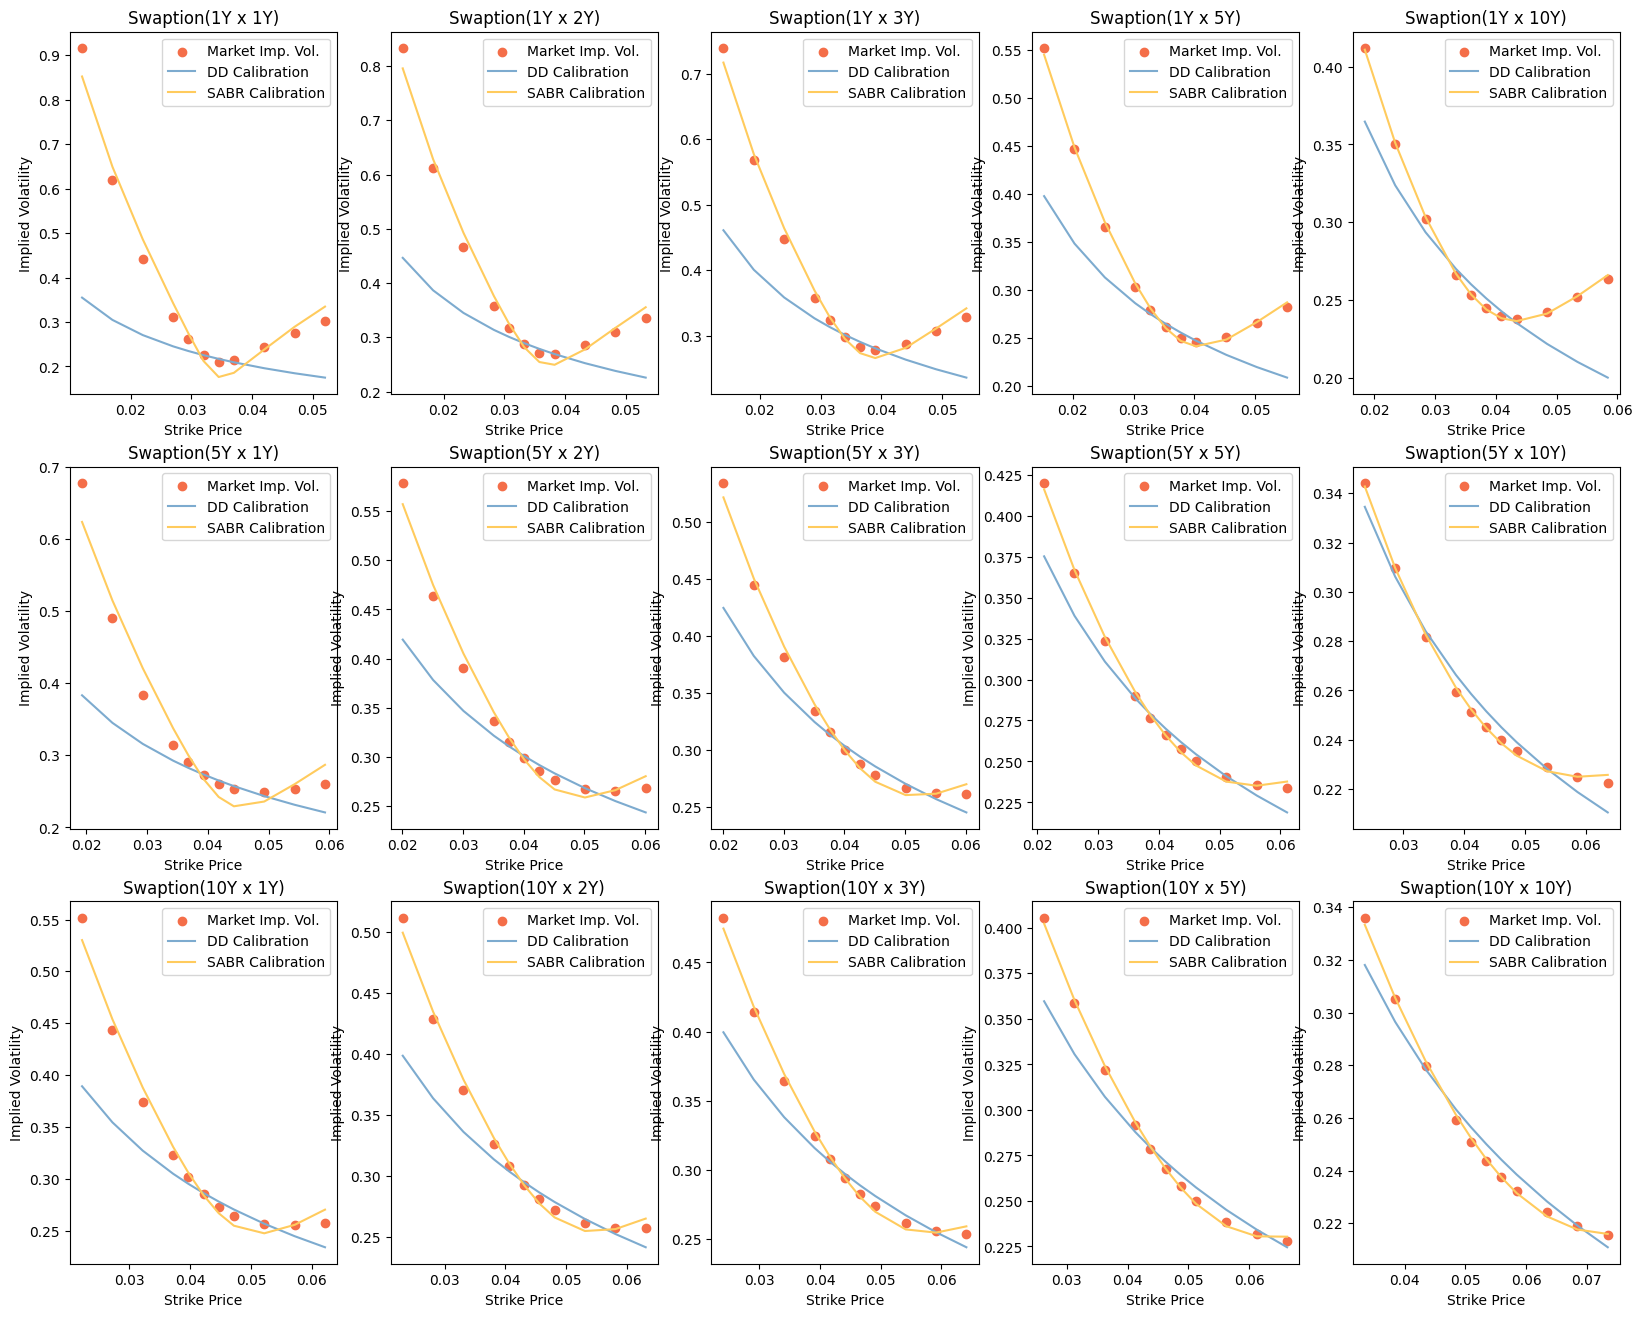

In [37]:
plt.figure(figsize=(20, 16))
for i in range(len(Swaption_data)):
    plt.subplot(3,5,i+1)
    draw_graph(i)

# <a id = "p5">5.</a>  <font color = "green"> Pricing Swaptions </font>  [back to table of contents](#top)

In [38]:
Calibration_parameters_df = pd.DataFrame({"start": swap_data1["Expiry"],
                                        "tenor": swap_data1["Tenor"],
                                        "Beta": beta_list,
                                        "alpha": fsr['alpha'],
                                        "rho": fsr['rho'],
                                        "nu": fsr['nu'],
                                        "sigma": swap_data1["ATM"]/100})

Calibration_parameters_df

,start,tenor,Beta,alpha,rho,nu,sigma
0,1,1,1.638113e-10,0.139074,-0.633223,2.049416,0.2250
1,1,2,9.815395e-08,0.184650,-0.525114,1.677383,0.2872
2,1,3,5.731735e-07,0.196851,-0.482848,1.438125,0.2978
3,1,5,9.601260e-07,0.178059,-0.414493,1.064842,0.2607
4,1,10,2.384479e-04,0.169984,-0.255690,0.792209,0.2447
5,5,1,2.484133e-07,0.166618,-0.585668,1.340427,0.2726
6,5,2,1.765342e-08,0.199534,-0.547030,1.062005,0.2983
7,5,3,4.283785e-06,0.210314,-0.549687,0.936773,0.2998
8,5,5,7.319718e-06,0.190244,-0.506814,0.674546,0.2660
9,5,10,1.081065e-01,0.174809,-0.415705,0.511310,0.2451


In [39]:
Calibration_parameters_df.to_csv("Calibration_parameters_df.csv",index=False)

In [40]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [41]:
def value_obtain(start,tenor,name):
    SABR_Alpha_10_1 = Calibration_parameters_df[Calibration_parameters_df["start"] == start]
    SABR_Alpha_10_1 = SABR_Alpha_10_1[SABR_Alpha_10_1["tenor"] == tenor][name]
    return float(SABR_Alpha_10_1)

In [42]:
def value_compute(start1,start2,tenor,name,start3):
    y1 = value_obtain(start1,tenor,name)
    y2 = value_obtain(start2,tenor,name)
    return interpol(start1,y1,start2,y2,start3)

In [43]:
Expiry = ['1Y', "2Y",'5Y','8Y', '10Y']
Tenor = ['1Y', "2Y", '3Y', '5Y','10Y']

fsw = []
for ex in Expiry:
    for te in Tenor:
        i = int(ex.strip()[:-1])
        j = int(te.strip()[:-1])
        deno = 0.5*sum(Discount_Factors.OIS_Discount_Factor[2*i:2*(i+j)])
        
        terms = []
        for x in range(2*i, 2*(i+j)):
            no = Discount_Factors.OIS_Discount_Factor[x] * (Discount_Factors.IRS_Discount_Factor[x-1] - Discount_Factors.IRS_Discount_Factor[x])/Discount_Factors.IRS_Discount_Factor[x]
            terms.append(no)
        numer = sum(terms)
        
        fsw.append(numer/deno)

fsw_array = np.array(fsw).reshape(5, 5)
forward_swap = pd.DataFrame(fsw_array, columns = Tenor, index = Expiry)
forward_swap

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
2Y,0.034516,0.035018,0.035018,0.037027,0.039634
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
8Y,0.041740,0.042646,0.042495,0.043512,0.048711
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [44]:
def Black76_Call(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76_Put(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, PVBP, beta, T):   
    return Black76_Call(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

def DD_Put(F, K, sigma, PVBP, beta, T):
    return Black76_Put(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

### <a id = "p5a">5a.</a>  <font color = "green"> Payer 2y x 10y </font>  [back to table of contents](#top)

In [45]:
dd_sigma_2_10 = value_compute(1,5,10,"sigma",2)
dd_Beta_2_10 = value_compute(1,5,10,"Beta",2)
SABR_Alpha_2_10 = value_compute(1,5,10,"alpha",2)
SABR_nu_2_10 = value_compute(1,5,10,"nu",2)
SABR_Rho_2_10 = value_compute(1,5,10,"rho",2)

print('\033[1mDisplaced Diffusion Model\033[0m')
print('Sigma, σ:', round(dd_sigma_2_10, 4))
print('Beta, β:', round(dd_Beta_2_10, 4))
\
print('\033[1mSABR Model\033[0m')
print('Alpha, α:', round(SABR_Alpha_2_10, 4))
print('Nu, ν:', round(SABR_nu_2_10, 4))
print('Rho, ρ:', round(SABR_Rho_2_10, 4))

Displaced Diffusion Model
Sigma, σ: 0.2448
Beta, β: 0.0272
SABR Model
Alpha, α: 0.1712
Nu, ν: 0.722
Rho, ρ: -0.2957


In [46]:
fwd1 = forward_swap.iloc[1,-1]
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = calc_pvbp(2, 12)

In [47]:
payer_DD = [DD_Call(fwd1, 
                    i, 
                    dd_sigma_2_10, 
                    pvbp1, 
                    dd_Beta_2_10, 
                    T) for i in strikes]  


 
payer_SABR=[Black76_Call(fwd1,
                         i,
                         SABR(fwd1,i,T,SABR_Alpha_2_10,0.9,SABR_Rho_2_10,SABR_nu_2_10),
                         pvbp1,
                         T) for i in strikes]

In [48]:
payer_2x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR}).T

payer_2x10.columns=payer_2x10.iloc[0]
payer_2x10 = payer_2x10.drop(['Strikes'], axis = 0)
payer_2x10

Strikes,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Displaced Diffusion,0.288117,0.194873,0.112259,0.051348,0.017436,0.004167,0.000676,0.000073
SABR,0.289694,0.198406,0.115133,0.051961,0.021482,0.011048,0.006966,0.004974


### <a id = "p5b">5b.</a>  <font color = "green"> Receiver 8y x 10y </font>  [back to table of contents](#top)

In [49]:
dd_sigma_8_10 = value_compute(5,10,10,"sigma",8)
dd_Beta_8_10 = value_compute(5,10,10,"Beta",8)
SABR_Alpha_8_10 = value_compute(5,10,10,"alpha",8)
SABR_nu_8_10 = value_compute(5,10,10,"nu",8)
SABR_Rho_8_10 = value_compute(5,10,10,"rho",8)


print('\033[1mDisplaced Diffusion Model\033[0m')
print('Sigma, σ:', round(dd_sigma_8_10, 4))
print('Beta, β:', round(dd_Beta_8_10, 4))
\
print('\033[1mSABR Model\033[0m')
print('Alpha, α:', round(SABR_Alpha_8_10, 4))
print('Nu, ν:', round(SABR_nu_8_10, 4))
print('Rho, ρ:', round(SABR_Rho_8_10, 4))

Displaced Diffusion Model
Sigma, σ: 0.2443
Beta, β: 0.0436
SABR Model
Alpha, α: 0.1781
Nu, ν: 0.5527
Rho, ρ: -0.4713


In [50]:
fwd2 = forward_swap.iloc[3,-1]
pvbp2 = calc_pvbp(8, 18)
T2 = 8

In [51]:
rec_DD = [DD_Put(fwd2, 
                 i, 
                 dd_sigma_8_10, 
                 pvbp2, 
                 dd_Beta_8_10, 
                 T2) for i in strikes]   

rec_SABR=[Black76_Put(fwd2,
                      i,
                      SABR(fwd2,i,T2,SABR_Alpha_8_10,0.9,SABR_Rho_8_10,SABR_nu_8_10)
                      ,pvbp2,
                      T2) for i in strikes]

In [52]:
receiver_8x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR}).T

receiver_8x10.columns=receiver_8x10.iloc[0]
receiver_8x10 = receiver_8x10.drop(['Strikes'], axis = 0)
receiver_8x10

Strikes,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Displaced Diffusion,0.018462,0.033376,0.056223,0.088755,0.132081,0.186413,0.251037,0.324505
SABR,0.019702,0.038962,0.061556,0.090482,0.130448,0.186470,0.258112,0.339643
